In [1]:
# Bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Leitura dos dados

demandareal = pd.read_excel("./setembro2021.xlsx")
demandareal = demandareal["CONSUMO"].values
teste = np.reshape(demandareal,(30,24))
# Função objetivo a ser minimizada, com penalidade de demanda

def fitness(individuo, demanda, volume_maximo, volume_minimo, custo, vazao, check=0):
    volume = volume_maximo

    fit = np.sum(custo[individuo])
    volume_t = individuo * vazao - demanda
    volume_t = np.array([volume] + list(volume_t))
    volume_t = np.cumsum(volume_t)

    # Verifica as restrições de volume mínimo e máximo
    volume_penal = np.maximum(volume_t - volume_maximo, 0) + np.maximum(volume_minimo - volume_t, 0)

    if check == 1:
        print(volume_penal, fit, len(volume_penal))

    # Calcula a aptidão considerando as restrições
    fit += np.sum(volume_penal)
    return fit

# Definição da tarifa:

def S(t):
    hora = t % 24  # Calcula a hora do dia a partir do índice t
    if hora >= 17 and hora < 21:  # Horário de ponta
        return 1.63527
    else:  # Horário fora de ponta
        return 0.62124
        
tarifa = np.array([S(i) for i in range(len(demandareal))])
# Seleção

def selecao(populacao, aptidao):
    aid = np.random.choice(len(populacao), size=2, replace=False)
    bid = np.random.choice(len(populacao), size=2, replace=False)
    
    aid = aid[np.argmax(aptidao[aid])]
    bid = bid[np.argmax(aptidao[bid])]
    a = populacao[aid]
    b = populacao[bid]
    apt = aptidao[aid]
    bpt = aptidao[bid]
    
    return np.array([a, b]), np.array([apt, bpt])
# Cruzamento

"""def cruzamento(pais,aptidao,probcruz):
    if(np.random.rand()<probcruz):
        p = 1 - aptidao/(np.sum(aptidao))
        filho = np.array([pais[0][i] if(np.random.rand() < p[0]) else pais[1][i] for i in range(pais.shape[1])])
    else:
        filho = pais[np.argmin(aptidao),:]
    return filho"""

def cruzamento(pais, probcruz):
    if np.random.rand() < probcruz:
        filho = np.empty_like(pais[0])
        for i in range(len(filho)):
            if np.random.rand() < 0.5:
                filho[i] = pais[0][i]
            else:
                filho[i] = pais[1][i]
    else:
        filho = pais[np.random.randint(0, 2)]
    
    return filho

# Mutação

def mutacao(individuo, probmut):
    n = len(individuo)
    copia = np.copy(individuo)
    num_mutacoes = int(probmut * n)
    idx = np.random.choice(n, size=num_mutacoes, replace=False)

    for i in range(num_mutacoes):
        gene = idx[i]
        novo_valor = np.random.uniform(0, 1)
        novo_gene = 0 if novo_valor <= 0.5 else 1
        copia[gene] = novo_gene

    return copia


def AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals):
    
    np.random.seed(424)
    num_genes = len(demandareal)
    populacao = np.random.choice([True, False], size=(num_individuals, num_genes))
    F = lambda individuo: fitness(individuo, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
    aptidao = np.array([F(individuo) for individuo in populacao])

    historico = []
    contador = 0

    while True:
        
        pais,apt = selecao(populacao,aptidao)

        filho = cruzamento(pais,probcruz)
        filho = mutacao(filho,probmut)

        populacao[np.argmax(aptidao),:] = filho
        aptidao[np.argmax(aptidao)] = F(filho)

        historico.append([aptidao[np.argmin(aptidao)],np.mean(aptidao)])

        if(np.mean(aptidao) - aptidao[np.argmin(aptidao)] < 1e-5):
            break
        contador += 1
        if(contador%1000 == 0):
            print(aptidao[np.argmin(aptidao)])
        if(aptidao[np.argmin(aptidao)] < 6000):
            break
        
    historico = np.array(historico)
    return historico, populacao[np.argmin(aptidao)]
# Número de indivíduos na população inicial
volume_maximo = 5
volume_minimo = 2
vazao = 2

In [3]:
# Parâmetros genéticos:

#probcruz = 0.6
#probmut = 0.05

num_individuals = 20 #tamanho da população

taxas_mutacao = [0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9]

resultados = []

for probmut in taxas_mutacao:
    for probcruz in taxas_cruzamento:
        dados, melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
        resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
        resultados.append((probmut, probcruz, resultado))

# Exibir os resultados
for resultado in resultados:
    probmut, probcruz, valor = resultado
    print(f"Taxa de Mutação: {probmut}, Taxa de Cruzamento: {probcruz}, Resultado: {valor}")


112240.65011000013
70479.40718000011
38623.099290000086
19740.013260000043
9083.187769999955
96677.50788000014
58307.860690000125
27548.746520000124
9834.258939999996
100882.70625000012
51915.99635000009
24843.431790000057
11556.974829999974
98055.55996000013
53089.863010000096
23901.382800000043
11945.152809999976
111934.70616000012
64599.110520000126
36973.69589000007
17841.85358
8250.442119999976
103609.54391000012
58770.819750000126
27252.821010000014
12696.560010000023
99179.65213000012
48818.29278000009
25164.838220000045
10318.106069999934
91887.39919000011
42136.42651000008
14972.56745999995
109132.96274000013
63004.7296700001
27590.681010000066
14382.378389999956
7436.681340000029
106775.01486000011
51792.920310000125
26599.70544000009
12548.22258
99690.55794000012
47520.77200000012
22072.825279999994
9528.67978999995
86593.15516000011
35068.48798000006
12579.569090000006
109132.96274000013
63004.7296700001
27590.681010000066
14382.378389999956
7436.681340000029
106775.0148600

In [ ]:
plt.plot(range(len(dados.T[0])),dados.T[0])
plt.plot(range(len(dados.T[0])),dados.T[1])
plt.grid()
plt.show()

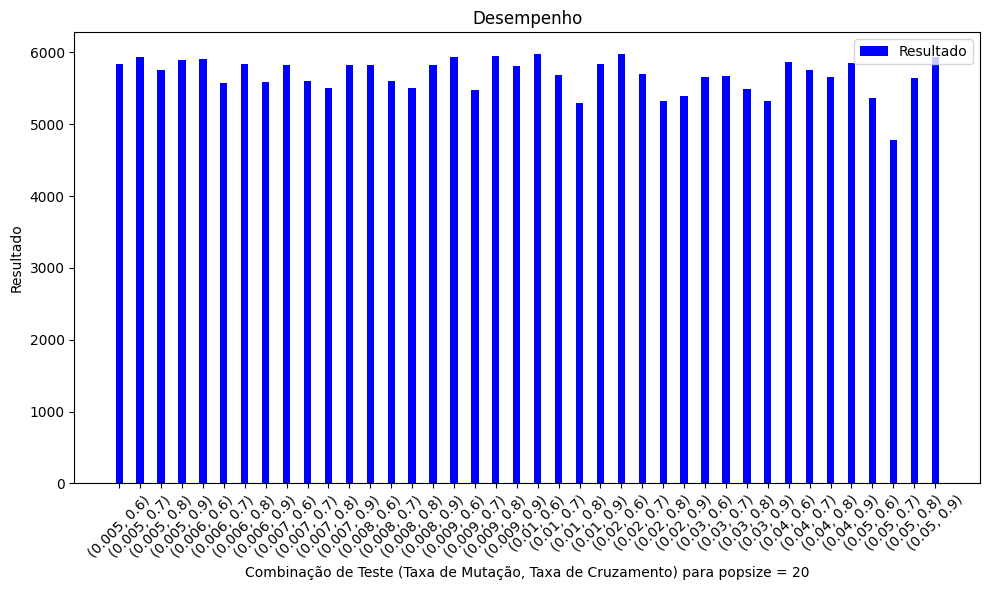

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados fornecidos
taxas_mutacao = [0.005, 0.005, 0.005, 0.005, 0.006, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.009, 0.009, 0.009, 0.009, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05, 0.05, 0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9]
resultados = [5840.948549999979, 5937.34848000001, 5756.1547599999785, 5892.738399999962, 5914.173209999974, 5573.871810000053, 5844.589330000014, 5588.005300000041, 5824.290570000024, 5600.420729999974, 5504.15243, 5820.6532799999995, 5824.290570000024, 5600.420729999974, 5504.15243, 5820.6532799999995, 5936.858860000025, 5476.5124300000125, 5942.977319999993, 5803.274759999994, 5979.620419999992, 5689.284060000022, 5292.615059999984, 5843.241109999962, 5973.304989999987, 5704.313050000007, 5318.036160000009, 5387.875839999952, 5659.619560000021, 5666.693050000029, 5483.028629999946, 5323.528789999973, 5858.914839999962, 5750.146850000072, 5657.613050000041, 5846.420959999986, 5363.345459999939, 4778.611730000051, 5638.995690000059, 5933.57499000005]

# Definição da legenda
legenda = ['Resultado']

# Aumento do tamanho da figura
fig, ax = plt.subplots(figsize=(10, 6))

# Configuração do gráfico
ind = np.arange(len(resultados))
width = 0.35
rects = ax.bar(ind, resultados, width, color='b', label=legenda[0])

# Configuração dos eixos
ax.set_xlabel('Combinação de Teste (Taxa de Mutação, Taxa de Cruzamento) para popsize = 20')
ax.set_ylabel('Resultado')
ax.set_title('Desempenho')

# Definindo rótulos do eixo x
rotulos = [f'({mutacao}, {cruzamento})' for mutacao, cruzamento in zip(taxas_mutacao, taxas_cruzamento)]
ax.set_xticks(ind)
ax.set_xticklabels(rotulos, rotation=45)

# Exibição da legenda
ax.legend(legenda)

# Exibição do gráfico
plt.tight_layout()
plt.show()


In [8]:
# Parâmetros genéticos:

#probcruz = 0.6
#probmut = 0.05

num_individuals = 50 #tamanho da população

taxas_mutacao = [0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9]

resultados = []

for probmut in taxas_mutacao:
    for probcruz in taxas_cruzamento:
        dados, melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
        resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
        resultados.append((probmut, probcruz, resultado))

# Exibir os resultados
for resultado in resultados:
    probmut, probcruz, valor = resultado
    print(f"Taxa de Mutação: {probmut}, Taxa de Cruzamento: {probcruz}, Resultado: {valor}")


139778.63801000014
101491.94469000012
67723.70796000012
47681.06007000008
29562.989460000004
19089.128149999946
11477.745989999958
7346.820259999983
134149.11902000013
87983.60005000012
49302.89596000012
25340.63566000002
13463.130479999983
7041.960489999985
124289.45569000012
77889.61407000013
42943.583790000084
23706.492329999997
13556.248389999992
6425.064759999978
110752.08499000012
56877.60014000013
27420.572330000097
12425.888929999946
6642.491810000029
131678.88653000013
94107.04694000012
60647.37238000012
38158.193480000016
25997.56488999998
14233.387149999966
8000.105989999982
133538.38554000013
82914.84982000013
54676.159210000114
30551.246280000065
19074.948150000004
9501.71683999997
113453.87654000011
69714.49921000014
34819.69240000007
18877.63163999994
10103.408469999975
6067.152039999985
124771.51181000011
76135.54944000013
37120.21179000007
15593.318310000019
6340.172279999958
136273.42359000014
91653.13663000011
60477.814790000106
40088.40201000005
26029.113030000015
1

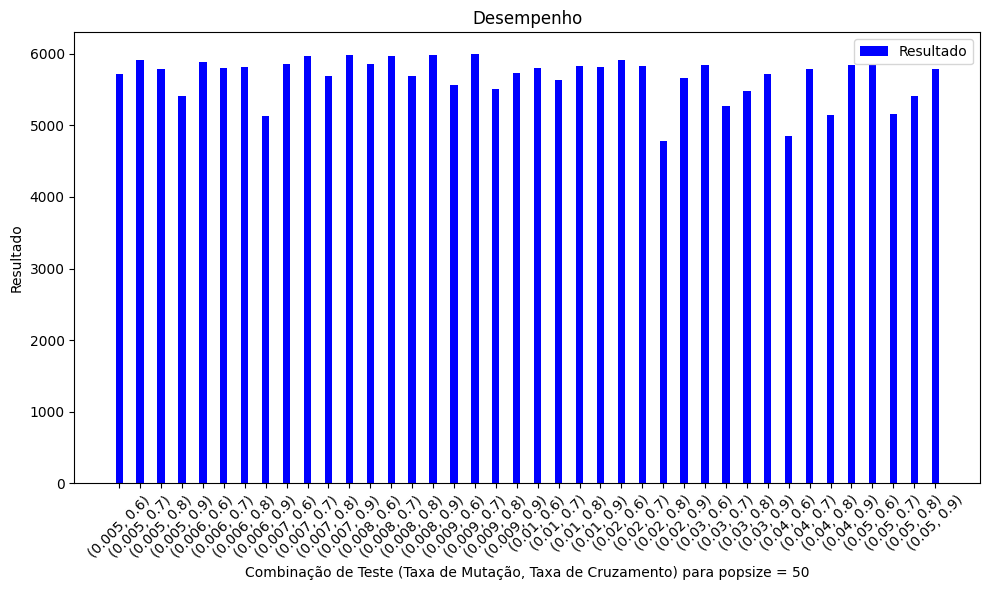

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados fornecidos
resultados = [5720.248090000022, 5916.686769999996, 5791.897389999956, 5410.393289999993, 5880.641499999956, 5801.305370000013, 5811.409560000067, 5131.124379999978, 5863.048940000012, 5972.416540000002, 5682.204290000023, 5975.933669999987, 5863.048940000012, 5972.416540000002, 5682.204290000023, 5975.933669999987, 5562.438479999982, 5998.458400000003, 5507.2605700000095, 5724.302670000001, 5804.661119999975, 5634.785539999999, 5824.25110999999, 5812.343910000012, 5919.0411099999965, 5825.675529999996, 4785.87079999999, 5655.722509999995, 5844.507929999959, 5270.807790000016, 5473.200340000062, 5712.854060000034, 4852.569330000034, 5790.440719999969, 5146.154759999972, 5843.149719999977, 5847.991659999978, 5153.788249999951, 5413.027940000003, 5790.8070900000475]

# Taxas de mutação e cruzamento correspondentes
taxas_mutacao = [0.005, 0.005, 0.005, 0.005, 0.006, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.009, 0.009, 0.009, 0.009, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05, 0.05, 0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9]

# Definição da legenda
legenda = ['Resultado']

# Aumento do tamanho da figura
fig, ax = plt.subplots(figsize=(10, 6))

# Configuração do gráfico
ind = np.arange(len(resultados))
width = 0.35
rects = ax.bar(ind, resultados, width, color='b', label=legenda[0])

# Configuração dos eixos
ax.set_xlabel('Combinação de Teste (Taxa de Mutação, Taxa de Cruzamento) para popsize = 50')
ax.set_ylabel('Resultado')
ax.set_title('Desempenho')

# Definindo rótulos do eixo x
rotulos = [f'({mutacao}, {cruzamento})' for mutacao, cruzamento in zip(taxas_mutacao, taxas_cruzamento)]
ax.set_xticks(ind)
ax.set_xticklabels(rotulos, rotation=45)

# Exibição da legenda
ax.legend(legenda)

# Exibição do gráfico
plt.tight_layout()
plt.show()
